In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
ts_df = pd.read_csv('/content/MET Office Weather Data.csv')

In [3]:
ts_1 = ts_df.drop('station', axis=1)

In [4]:
ts_1

,year,month,tmax,tmin,af,rain,sun
0,1941.0,1.0,NaN,NaN,NaN,74.7,NaN
1,1941.0,2.0,NaN,NaN,NaN,69.1,NaN
2,1941.0,3.0,NaN,NaN,NaN,76.2,NaN
3,1941.0,4.0,NaN,NaN,NaN,33.7,NaN
4,1941.0,5.0,NaN,NaN,NaN,51.3,NaN
...,...,...,...,...,...,...,...
37044,2020.0,2.0,10.8,4.5,2.0,117.4,63.1
37045,2020.0,3.0,11.5,3.0,6.0,43.4,159.2
37046,2020.0,4.0,17.5,5.3,3.0,39.8,235.0
37047,2020.0,5.0,19.7,6.8,2.0,3.6,305.6


In [5]:
ts = ts_1['tmax'].dropna().interpolate().tolist()

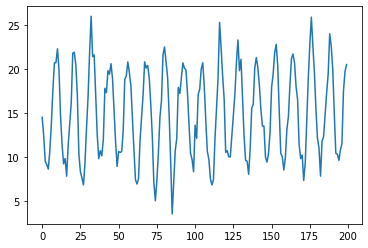

In [6]:
plt.plot(ts[-200:])

In [7]:
import torch 
import torch.nn.functional as F 

In [8]:
class DL(torch.nn.Module):
    def __init__(self, n_inp, l_1, l_2, conv1_out, conv1_kernel, conv2_kernel, drop1=0):
        super(DL, self).__init__()
        conv1_out_ch = conv1_out
        conv2_out_ch = conv1_out * 2
        conv1_kernel = conv1_kernel
        conv2_kernel = conv2_kernel
        self.dropout_lin1 = drop1
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=conv1_out_ch, kernel_size=conv1_kernel, padding= conv1_kernel-1)
        self.conv2 = torch.nn.Conv1d(in_channels=conv1_out_ch, out_channels=conv2_out_ch, kernel_size=conv2_kernel, padding=conv2_kernel-1)

        feature_tensor = self.feature_stack(torch.Tensor([[0]*n_inp]))
        self.lin1 = torch.nn.Linear(feature_tensor.size()[1], l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2,1)
        
    def feature_stack(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.flatten(start_dim=1)
        return x

    def fc_stack(self, x):
        x1 = F.relu(self.lin1(x))
        # x1 = F.relu(self.dropout_lin1)
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y 

    def forward(self,x):
        x = self.feature_stack(x)
        y = self.fc_stack(x)
        return y 

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch

class SarimaxPredictor(torch.nn.Module):
    def forward(self,x):
        last_values = []
        l = x.tolist()
        counter = 0

        for r in l:
            model = SARIMAX(r, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
            results = model.fit(disp=0)
            forecast = results.forecast()
            last_values.append([forecast[0]])
            counter =+ 1
            print(f'debug: SARIM CALCLATION {counter}/{len(l)}')

        return torch.tensor(data = last_values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
class HwesPredictor(torch.nn.Module):
    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r, trend = None, seasonal = 'add', seasonal_periods=12)
            result = model.fit()
            forecast = result.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)

In [11]:
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y

In [12]:
def get_training_datasets(features, test_len, ts):
    ts = ts 
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len], \
                                       Y[0:-test_len], \
                                       X[-test_len:], \
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [13]:
import copy 
import random
import sys

random.seed(1)
torch.manual_seed(1)

features = 120 

x_train, x_val, x_test, y_train, y_val, y_test = \
    get_training_datasets(features, 60, ts =ts )

In [14]:
net = DL(
    n_inp = features,
    l_1 = 400,
    l_2 = 48,
    conv1_out = 6,
    conv1_kernel = 36,
    conv2_kernel = 12,
    drop1 = 0.1,
) 
net.train()

DL(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 6, kernel_size=(36,), stride=(1,), padding=(35,))
  (conv2): Conv1d(6, 12, kernel_size=(12,), stride=(1,), padding=(11,))
  (lin1): Linear(in_features=528, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=48, bias=True)
  (lin3): Linear(in_features=48, out_features=1, bias=True)
)

In [15]:
sarima_predictor = SarimaxPredictor()
hwes_predictor = HwesPredictor()

In [16]:


optimizer = torch.optim.Adam(params=net.parameters())
abs_loss = torch.nn.L1Loss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(150):

    prediction = net(x_train)
    loss = abs_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = abs_loss(val_prediction, y_val)
    
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()

    if t % 10 ==0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, '
              f'val: - {round(val_loss.item(), 4)}')
            


epoch 0: train - 12.8265, val: - 11.4434
epoch 10: train - 4.0648, val: - 3.5937
epoch 20: train - 3.3811, val: - 3.0179
epoch 30: train - 2.0305, val: - 1.5788
epoch 40: train - 1.9719, val: - 1.5223
epoch 50: train - 1.775, val: - 1.469
epoch 60: train - 1.6285, val: - 1.3326
epoch 70: train - 1.5089, val: - 1.2795
epoch 80: train - 1.4538, val: - 1.2549
epoch 90: train - 1.4077, val: - 1.2143
epoch 100: train - 1.3664, val: - 1.1797
epoch 110: train - 1.3364, val: - 1.1585
epoch 120: train - 1.3223, val: - 1.1508
epoch 130: train - 1.304, val: - 1.1381
epoch 140: train - 1.2898, val: - 1.1292


In [17]:
dl_prediction = best_model(x_test)
sarima_prediction = sarima_predictor(x_test)
hwes_prediction = hwes_predictor(x_test)

dl_abs_loss = round(abs_loss(dl_prediction, y_test).item(), 4)
sarima_abs_loss = round(abs_loss(sarima_prediction, y_test).item(), 4)
hwes_abs_loss = round(abs_loss(hwes_prediction, y_test).item(), 4)

print('===')
print('Results on Test Dataset')
print(f'DL Loss: {dl_abs_loss}')
print(f'SARIMA Loss: {sarima_abs_loss}')
print(f'HWES Loss: {hwes_abs_loss}')

debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM CALCLATION 1/60
debug: SARIM C

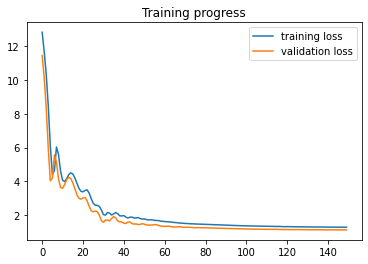

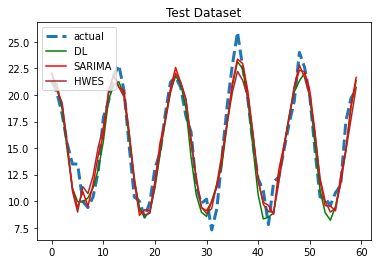

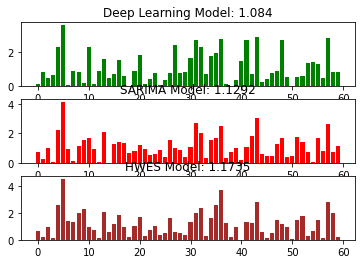

In [18]:
plt.title("Training progress")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

plt.title('Test Dataset')
plt.plot(y_test, '--', label = 'actual', linewidth = 3)
plt.plot(best_model(x_test).tolist(), label = 'DL', color = 'g')
plt.plot(sarima_prediction.tolist(), label = 'SARIMA', color = 'r')
plt.plot(hwes_prediction.tolist(), label = 'HWES', color = 'brown')
plt.legend()
plt.show()

test_n = len(y_test)
dl_abs_dev = (dl_prediction - y_test).abs_()
sarima_abs_dev = (sarima_prediction - y_test).abs_()
hwes_abs_dev = (hwes_prediction - y_test).abs_()

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.set_title(f'Deep Learning Model: {dl_abs_loss}')
ax1.bar(list(range(test_n)), dl_abs_dev.view(test_n).tolist(), color = 'g')

ax2.set_title(f'SARIMA Model: {sarima_abs_loss}')
ax2.bar(list(range(test_n)), sarima_abs_dev.view(test_n).tolist(), color = 'r')

ax3.set_title(f'HWES Model: {hwes_abs_loss}')
ax3.bar(list(range(test_n)), hwes_abs_dev.view(test_n).tolist(), color = 'brown')

plt.show()